# Imports

In [35]:
import pandas as pd
import numpy as np
import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification
import os
import re
import json
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from tqdm import tqdm
import torch.nn as nn
from sklearn.metrics import f1_score, classification_report
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import string

# Configuration

In [36]:
class Config:
    CLS = [101]
    SEP = [102]
    VALUE_TOKEN = [0]
    MAX_LEN = 512
    TRAIN_BATCH_SIZE = 5
    VAL_BATCH_SIZE = 5
    EPOCHS = 8
    DROPOUT = 0.35
    MODEL_NAME = 'dslim/bert-base-NER'
    TOKENIZER = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False, model_max_length=512)
    
device =  "cuda" if torch.cuda.is_available() else "cpu"

# Data Preprocessing
#### The goal is to convert the JSON file to a data frame that will hold arrays of words and tags respectively.
#### Steps: 
1. Convert Json to word-tag dataframe
2. Encode tags
3. Group By Sentences

In [59]:
#Load File
data_file_address = "../input/resume-entities-for-ner//Entity Recognition in Resumes.json"
df_data = pd.read_json(data_file_address, lines = True)
df_data.head()

,content,annotation,extras
0,Abhishek Jha\nApplication Development Associat...,"[{'label': ['Skills'], 'points': [{'start': 12...",NaN
1,Afreen Jamadar\nActive member of IIIT Committe...,"[{'label': ['Email Address'], 'points': [{'sta...",NaN
2,"Akhil Yadav Polemaina\nHyderabad, Telangana - ...","[{'label': ['Skills'], 'points': [{'start': 37...",NaN
3,Alok Khandai\nOperational Analyst (SQL DBA) En...,"[{'label': ['Skills'], 'points': [{'start': 80...",NaN
4,Ananya Chavan\nlecturer - oracle tutorials\n\n...,"[{'label': ['Degree'], 'points': [{'start': 20...",NaN


In [60]:
# Function to extract word-tag pairs from the content
def extract_word_tag_pairs(content, annotations):
    annotations = sorted(annotations, key=lambda x: x['points'][0]['start'])  # Step 1: Sort annotations by 'start'
    word_tag_pairs = []
    current_pos = 0  # Step 2: Keep track of character position
    
    for ann in annotations:
        start = ann['points'][0]['start']
        end = ann['points'][0]['end'] + 1
        tag = ann['label'][0] if ann['label'] else 'O'
        
        if tag == 'UNKNOWN':
            tag = 'O'
        
        # Process untagged text before the current annotation
        if current_pos < start:
            untagged_text = content[current_pos:start].strip()
            if untagged_text:
                for word in untagged_text.split():
                    word_tag_pairs.append((word, 'O'))
        
        # Process annotated text
        annotated_text = content[start:end].strip()
        if annotated_text:
            for word in annotated_text.split():
                word_tag_pairs.append((word, tag))
        
        current_pos = end  # Update the current position to the end of this annotation

    # Process any remaining untagged text after the last annotation
    if current_pos < len(content):
        untagged_text = content[current_pos:].strip()
        if untagged_text:
            for word in untagged_text.split():
                word_tag_pairs.append((word, 'O'))
    
    # Merge consecutive 'Email Address' tags into a single entity
    merged_word_tag_pairs = []
    email_sequence = []
    email_tag = 'Email Address'
    
    for word, tag in word_tag_pairs:
        if tag == email_tag and word != 'Indeed:':
            email_sequence.append(word)
        else:
            if email_sequence:  # If there is a sequence to merge
                merged_word_tag_pairs.append((" ".join(email_sequence), email_tag))
                #merged_word_tag_pairs.append(("<EMAIL>", email_tag))
                email_sequence = []
            merged_word_tag_pairs.append((word, tag))
    
    # Append any remaining 'EMAIL ADDRESS' sequence
    if email_sequence:
        merged_word_tag_pairs.append((" ".join(email_sequence), email_tag))
    
    return merged_word_tag_pairs

# Create the DataFrame with # Document, Word, Tag
result = []
for index, row in df_data.iterrows():
    content = row['content']
    annotations = row['annotation']
    word_tag_pairs = extract_word_tag_pairs(content, annotations)
    
    for word, tag in word_tag_pairs:
        result.append([index, word, tag])

words_tags_df = pd.DataFrame(result, columns=['Document', 'Word', 'Tag'])

In [61]:
# Check documet words and tags
words_tags_df[words_tags_df['Document'] == 0].head(20)

,Document,Word,Tag
0,0,Abhishek,Name
1,0,Jha,Name
2,0,Application,Designation
3,0,Development,Designation
4,0,Associate,Designation
5,0,-,O
6,0,Accenture,Companies worked at
7,0,Bengaluru,Location
8,0,",",O
9,0,Karnataka,O


In [62]:
#Checking Missing Values
words_tags_df.isna().sum(axis=0)

Document    0
Word        0
Tag         0
dtype: int64

In [63]:
#Tag Label Counts
words_tags_df.Tag.value_counts()

O                      101572
Skills                   7751
Designation              1423
College Name             1225
Companies worked at      1172
Degree                   1119
Name                      460
Location                  459
Email Address             259
Graduation Year           256
Years of Experience        89
Name: Tag, dtype: int64

In [64]:
'''
# Function to modify tags
def modify_tags(df):
    new_tags = []
    current_tag = None
    
    for index, row in df.iterrows():
        tag = row['Tag']
        
        if tag == 'O':
            new_tags.append('O')
        else:
            if tag != current_tag:  # New tag sequence
                new_tags.append(f'B-{tag}')
                current_tag = tag
            else:  # Same tag sequence
                new_tags.append(f'I-{tag}')
    
    df['Tag'] = new_tags
    
# Modify the tags in the DataFrame
modify_tags(words_tags_df)
words_tags_df.Tag.value_counts()
'''

"\n# Function to modify tags\ndef modify_tags(df):\n    new_tags = []\n    current_tag = None\n    \n    for index, row in df.iterrows():\n        tag = row['Tag']\n        \n        if tag == 'O':\n            new_tags.append('O')\n        else:\n            if tag != current_tag:  # New tag sequence\n                new_tags.append(f'B-{tag}')\n                current_tag = tag\n            else:  # Same tag sequence\n                new_tags.append(f'I-{tag}')\n    \n    df['Tag'] = new_tags\n    \n# Modify the tags in the DataFrame\nmodify_tags(words_tags_df)\nwords_tags_df.Tag.value_counts()\n"

In [65]:
#Filling Missing Values and Label Encoding
le = LabelEncoder().fit(words_tags_df['Tag'])
words_tags_df['Tag'] = le.transform(words_tags_df['Tag'])
words_tags_df.head(10)

,Document,Word,Tag
0,0,Abhishek,7
1,0,Jha,7
2,0,Application,3
3,0,Development,3
4,0,Associate,3
5,0,-,8
6,0,Accenture,1
7,0,Bengaluru,6
8,0,",",8
9,0,Karnataka,8


In [66]:
#Group By Sentences
data_gr = words_tags_df.groupby("Document").agg({'Word': list, 'Tag':list})
final_data_gr = data_gr.copy()
print("Sentences in data:", len(data_gr))
data_gr.head()

Sentences in data: 220


,Word,Tag
Document,,
0,"[Abhishek, Jha, Application, Development, Asso...","[7, 7, 3, 3, 3, 8, 1, 6, 8, 8, 8, 8, 8, 8, 4, ..."
1,"[Afreen, Jamadar, Active, member, of, IIIT, Co...","[7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, ..."
2,"[Akhil, Yadav, Polemaina, Hyderabad, ,, Telang...","[7, 7, 7, 6, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, ..."
3,"[Alok, Khandai, Operational, Analyst, (SQL, DB...","[7, 7, 3, 3, 3, 3, 3, 8, 1, 6, 8, 8, 8, 8, 8, ..."
4,"[Ananya, Chavan, lecturer, -, oracle, tutorial...","[7, 7, 3, 8, 1, 1, 6, 8, 8, 8, 8, 8, 8, 8, 4, ..."


In [67]:
# Limit sentences
LIMIT = False
LIMIT_BY = 5000

if LIMIT:
    final_data_gr = data_gr.head(LIMIT_BY)

In [68]:
#Train Test Split
train_sent, val_sent = train_test_split(final_data_gr, test_size=0.15, random_state=10)
print("Train documents: ",len(train_sent))
print("Validation documents: ",len(val_sent))

Train documents:  187
Validation documents:  33


# Create DataSet

In [69]:
class Dataset(Dataset):
    def __init__(self, words_tags_df):
        self.texts = words_tags_df['Word'].tolist()
        self.tags = words_tags_df['Tag'].tolist()
  
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        texts = self.texts[index]
        tags = self.tags[index]

        # Tokenize
        ids = []
        target_tag = []

        for i, s in enumerate(texts):
            inputs = Config.TOKENIZER.encode(s, add_special_tokens=False)
            input_len = len(inputs)
            ids.extend(inputs)
            target_tag.extend(input_len * [tags[i]])
        
        # To Add Special Tokens, subtract 2 from MAX_LEN
        ids = ids[:Config.MAX_LEN - 2]
        target_tag = target_tag[:Config.MAX_LEN - 2]

        # Add Special Tokens
        ids = Config.CLS + ids + Config.SEP
        target_tags = Config.VALUE_TOKEN + target_tag + Config.VALUE_TOKEN

        mask = [1] * len(ids)
        token_type_ids = [0] * len(ids)

        # Add Padding if the input_len is small
        padding_len = Config.MAX_LEN - len(ids)
        ids = ids + ([0] * padding_len)
        target_tags = target_tags + ([0] * padding_len)
        mask = mask + ([0] * padding_len)
        token_type_ids = token_type_ids + ([0] * padding_len)

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "target_tags": torch.tensor(target_tags, dtype=torch.long)
        }

In [70]:
# Create DataLoaders
train_dataset = Dataset(train_sent)

val_dataset = Dataset(val_sent)
val_dl = DataLoader(val_dataset, batch_size=Config.VAL_BATCH_SIZE, pin_memory=True)

# Build a Model, Calculate Loss

In [71]:
class NERBertModel(nn.Module):
    
    def __init__(self, num_tag):
        super(NERBertModel, self).__init__()
        self.num_tag = num_tag
        model = AutoModelForTokenClassification.from_pretrained(Config.MODEL_NAME)
        model.dropout = torch.nn.Dropout(p=Config.DROPOUT)
        model.classifier = torch.nn.Linear(in_features=768, out_features=self.num_tag, bias=True)
        self.bert = model
        
    def forward(self, ids, mask, token_type_ids, target_tags):

        tag_logits = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)[0]
        
        loss = None
        
        # Calculate the loss only if target tags are provided
        criterion_loss = nn.CrossEntropyLoss()

        # Flatten mask, logits, and target tags for loss calculation
        active_loss = mask.view(-1) == 1
        active_logits = tag_logits.view(-1, self.num_tag)

        # Ensure ignore index is on the same device
        ignore_index = torch.tensor(criterion_loss.ignore_index).type_as(target_tags)
        active_labels = torch.where(active_loss, target_tags.view(-1), ignore_index)

        # Compute the loss
        loss = criterion_loss(active_logits, active_labels)
        
        return tag_logits, loss

# Training and Evaluation Functions

In [72]:
def train_and_validate(model, train_dataset, validation_loader, optimizer, epochs=5, train_loss_threshold=None, verbose=True):
    train_running_loss_history = []
    validation_running_loss_history = []
    lr_history = []
    prev_val_loss = float('inf')
    early_stop = False

    # Calculate the total number of steps in one cycle (total batches across all epochs)
    num_batches = (len(train_dataset) + Config.TRAIN_BATCH_SIZE - 1) // Config.TRAIN_BATCH_SIZE
    total_steps = epochs * num_batches
    
    # Define the OneCycleLR scheduler
    init_lr = optimizer.param_groups[0]['lr']
    scheduler = OneCycleLR(optimizer, max_lr=init_lr * 10, total_steps=total_steps)
    
    with tqdm(total=epochs, desc="Training Progress", leave=True, dynamic_ncols=True) as progress_bar:
        for e in range(epochs):
            train_running_loss = 0.0
            validation_running_loss = 0.0
            train_loader = DataLoader(train_dataset, batch_size=Config.TRAIN_BATCH_SIZE, shuffle=True, pin_memory=True)

            if early_stop:
                break

            model.train()
            # Training loop
            for ith_batch, sample_batched in enumerate(train_loader):
                for indx, val in sample_batched.items():
                    sample_batched[indx] = val.to(device)

                optimizer.zero_grad()
                _, loss = model(**sample_batched)

                if loss.ndimension() > 0:
                    loss = loss.mean()

                # Backward and optimize
                loss.backward()
                optimizer.step()

                train_running_loss += loss.item()

                # Step the scheduler
                scheduler.step()
                lr_history.append(optimizer.param_groups[0]['lr'])

            # Validation loop
            with torch.no_grad():
                model.eval()
                for ith_batch, sample_batched in enumerate(validation_loader):
                    for indx, val in sample_batched.items():
                        sample_batched[indx] = val.to(device)

                    _, val_loss = model(**sample_batched)

                    if val_loss.ndimension() > 0:
                        val_loss = val_loss.mean()

                    validation_running_loss += val_loss.item()

                train_epoch_loss = train_running_loss / len(train_loader)
                validation_epoch_loss = validation_running_loss / len(validation_loader)

                train_running_loss_history.append(train_epoch_loss)
                validation_running_loss_history.append(validation_epoch_loss)
                
                # Update tqdm with train and validation loss for the current epoch
                progress_bar.set_description(f"Epoch {e+1}: Train Loss = {train_epoch_loss:.5f}, Val Loss = {validation_epoch_loss:.5f}")
                progress_bar.update(1)

                if train_loss_threshold is not None:
                    if train_epoch_loss < train_loss_threshold and validation_epoch_loss >= prev_val_loss:
                        progress_bar.set_description(f"Stopping early: Train Loss = {train_epoch_loss:.5f}, Val Loss = {validation_epoch_loss:.5f}")
                        early_stop = True
                    prev_val_loss = validation_epoch_loss

            torch.cuda.empty_cache()

    # Plot loss history
    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_running_loss_history, label='Train Loss')
    plt.plot(validation_running_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot learning rate
    plt.subplot(1, 2, 2)
    plt.plot(lr_history, label='Learning Rate')
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Train The Model

In [73]:
def get_parameters(model, full_finetuning):
    if full_finetuning:
        onedim_params = [p for p in model.parameters() if p.ndim == 1]
        other_params = [p for p in model.parameters() if p.ndim != 1]
    else:
        onedim_params = [p for p in model.bert.classifier.parameters() if p.ndim == 1]
        other_params = [p for p in model.bert.classifier.parameters() if p.ndim != 1]

    parameters = [
        {'params': other_params},
        {'params': onedim_params, 'weight_decay': 0}
    ]
    
    return parameters

Stopping early: Train Loss = 0.17203, Val Loss = 0.34930: 100%|██████████| 8/8 [02:31<00:00, 18.90s/it]


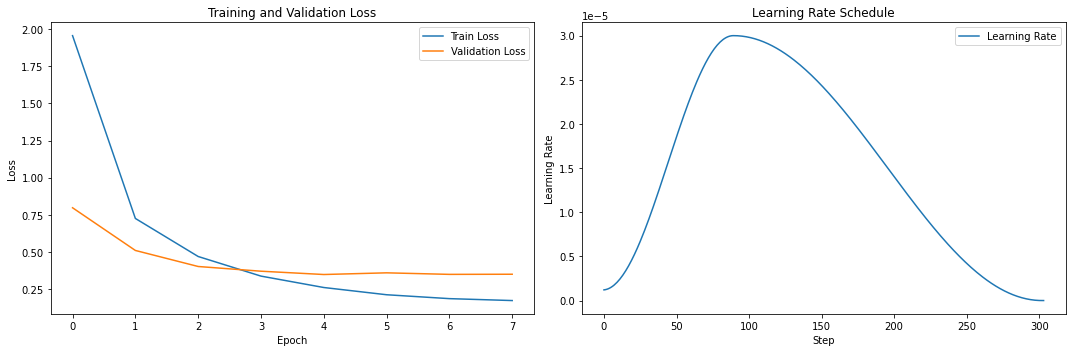

In [74]:
# Define your hyperparameters
epochs = Config.EPOCHS
learning_rate = 0.00003
weight_decay = 0.005

# Load pre-trained model
num_tag = len(words_tags_df.Tag.value_counts())
model = NERBertModel(num_tag=num_tag)
model.to(device)

optimizer_params = get_parameters(model, True)

full_opt = optim.AdamW(optimizer_params, lr=learning_rate/10, weight_decay=weight_decay)

# Use DataParallel for multi-GPU training
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

model.to(device)

train_and_validate(model, train_dataset, val_dl, full_opt, epochs, train_loss_threshold=0.2)

# Prediction

In [75]:
def prediction(val_sample_indx, model, max_rows=None):
    # Split the sentence into words
    words = val_dataset.texts[val_sample_indx]
    words_len = len(words)
    
    # Tokenize words and track token counts per word, up to the model's max length
    token_lengths = []  # Store the number of tokens for each word
    total_tokens = 0
    for word in words:
        token_count = len(Config.TOKENIZER.encode(word, add_special_tokens=False))
        
        # Stop adding tokens if we reach or exceed the max length
        if total_tokens + token_count >= Config.MAX_LEN - 2:  # account for CLS and SEP tokens
            break
        token_lengths.append(token_count)
        total_tokens += token_count

    with torch.no_grad():
        model.eval()
        data = val_dataset[val_sample_indx]
        for i, j in data.items():
            data[i] = j.to(device).unsqueeze(0)

        # Get model predictions
        tag_logits, _ = model(**data)

        # Get predictions by taking the argmax of the logits along the last dimension
        pred_tags = torch.argmax(tag_logits, dim=-1)

        # Flatten the mask and apply it to filter out padding tokens
        active_mask = data['mask'].view(-1) == 1  # Get the active tokens
        active_pred_tags = pred_tags.view(-1)[active_mask]
        
        # Map the predicted tag indices to label names
        predicted_token_tags = le.inverse_transform(active_pred_tags.cpu().numpy())[1:]
        
    # Assign the first tag of each word's tokens as the predicted tag for the word
    predicted_tags = []
    start_idx = 0
    for token_len in token_lengths:
        if start_idx < len(predicted_token_tags):
            predicted_tags.append(predicted_token_tags[start_idx])  # Take the first tag of this word's tokens
            start_idx += token_len  # Move to the next word's tokens
        else:
            break

    # Limit rows displayed based on max_rows
    if max_rows is not None:
        words = words[:max_rows]
        predicted_tags = predicted_tags[:max_rows]

    # Print results in a tabular format
    print("\nWord-Prediction Pairs:")
    print("-" * 30)
    for word, pred_tag in zip(words, predicted_tags):
        print(f"{word:<15} -> {pred_tag}")
    print("-" * 30)
    
    # Optionally print if there are more rows
    if max_rows and words_len > max_rows:
        print(f"...and {words_len - max_rows} more rows.")

In [76]:
val_sample_indx = 1
prediction(val_sample_indx, model, 30)


Word-Prediction Pairs:
------------------------------
Shrinidhi       -> Name
Selva           -> Name
Kumar           -> Name
NOC             -> Designation
and             -> Designation
QA              -> Designation
Engineer        -> Designation
at              -> Designation
Skava           -> Companies worked at
an              -> Companies worked at
Infosys         -> Companies worked at
Company         -> Companies worked at
-               -> O
Data            -> Companies worked at
Mining          -> Companies worked at
Coimbatore      -> Location
,               -> O
Tamil           -> O
Nadu            -> O
-               -> O
Email           -> O
me              -> O
on              -> O
Indeed:         -> O
indeed.com/r/Shrinidhi-Selva- Kumar/50d8e59fabb41a63 -> Email Address
Willing         -> O
to              -> O
relocate        -> O
to:             -> O
Chennai,        -> O
------------------------------
...and 102 more rows.


In [77]:
tag_names = le.classes_
print(tag_names)
tag_labels = le.transform(tag_names)
print(tag_labels)

['College Name' 'Companies worked at' 'Degree' 'Designation'
 'Email Address' 'Graduation Year' 'Location' 'Name' 'O' 'Skills'
 'Years of Experience']
[ 0  1  2  3  4  5  6  7  8  9 10]


# Evaluation

In [78]:
# Initialize lists to store true labels and predictions
all_preds = []
all_labels = []

# Validation loop
with torch.no_grad():
    model.eval()
    for sample_batched in tqdm(val_dl, total=len(val_dl)):
        for indx, val in sample_batched.items():
            sample_batched[indx] = val.to(device)
        
        # Get model output (logits) and loss
        tag_logits, _ = model(**sample_batched)
        
        # Get predictions by taking the argmax of the logits along the last dimension (tags dimension)
        pred_tags = torch.argmax(tag_logits, dim=-1)
        
        # Flatten the mask and apply it to the labels and predictions to ignore padding tokens
        active_mask = sample_batched['mask'].view(-1) == 1  # Get the active tokens
        active_pred_tags = pred_tags.view(-1)[active_mask]   # Only keep predictions for non-padding tokens
        active_true_tags = sample_batched['target_tags'].view(-1)[active_mask]  # True tags without padding
        
        # Append predictions and true labels to lists
        all_preds.extend(active_pred_tags.cpu().numpy())
        all_labels.extend(active_true_tags.cpu().numpy())

# Identify present labels
present_labels = list(set(all_labels) & set(all_preds))

# Filter out labels not in tag_labels
valid_labels = [label for label in present_labels if label in tag_labels]

# Create a filtered version of tag_names and tag_labels
filtered_tag_names = [tag_names[i] for i, label in enumerate(tag_labels) if label in valid_labels]
filtered_tag_labels = [label for label in tag_labels if label in valid_labels]

# Generate classification report with the filtered labels
report = classification_report(
    all_labels,
    all_preds,
    target_names=filtered_tag_names,
    labels=filtered_tag_labels,
)
print(report)

# Optionally, calculate F1 score for a specific average
f1 = f1_score(all_labels, all_preds, labels=filtered_tag_labels, average='weighted')
print(f"F1 Score (weighted): {f1}")

100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


                     precision    recall  f1-score   support

       College Name       0.78      0.73      0.75       191
Companies worked at       0.55      0.66      0.60       308
             Degree       0.55      0.53      0.54        91
        Designation       0.71      0.63      0.67       355
      Email Address       0.78      0.86      0.82       825
           Location       0.70      0.63      0.66       120
               Name       0.96      0.97      0.96       176
                  O       0.94      0.93      0.94     13112
             Skills       0.40      0.37      0.38       686

          micro avg       0.89      0.89      0.89     15864
          macro avg       0.71      0.70      0.70     15864
       weighted avg       0.89      0.89      0.89     15864

F1 Score (weighted): 0.8866498129793033
